## Лабораторная работа 5: Обучение и тестирование модели

imports


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import random
import matplotlib.pyplot as plt

Model Definition

define a simple CNN model using PyTorch's nn.Module class.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2) -> None:
        """
        Simple Convolutional Neural Network (CNN) model.

        Parameters:
        - num_classes: Number of classes for classification.
        """
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

Dataset Class


create a custom dataset class for image classification.


In [11]:
class CustomDataset(Dataset):
    def __init__(
        self,
        img_paths: list,
        labels: list,
        transform: transforms.Compose = None,
        label_mapping: dict = None,
    ) -> None:
        """
        Custom dataset class for image classification.

        Parameters:
        - img_paths: List of image file paths.
        - labels: List of corresponding labels.
        - transform: Image transformations.
        - label_mapping: Mapping of label strings to numerical indices.
        """
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self) -> int:
        """
        Get the length of the dataset.

        Returns:
        - int: Length of the dataset.
        """
        return len(self.img_paths)

    def __getitem__(self, idx: int) -> tuple:
        """
        Get item from the dataset.

        Parameters:
        - idx: Index of the item.

        Returns:
        - tuple: (image, label)
        """
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label_str = self.labels[idx]
        label = self.label_mapping[label_str] if self.label_mapping else int(
            label_str)

        return img, torch.tensor(label)


def split_dataset(
    img_list: list,
    labels: list,
    train_size: float = 0.8,
    val_size: float = 0.1,
    test_size: float = 0.1,
) -> tuple:
    """
    Split the dataset into training, validation, and test sets.

    Parameters:
    - img_list: List of image file paths.
    - labels: List of corresponding labels.
    - train_size: Percentage of data for training.
    - val_size: Percentage of data for validation.
    - test_size: Percentage of data for testing.

    Returns:
    - tuple: img_train, labels_train, img_val, labels_val, img_test, labels_test
    """
    total_size = len(img_list)

    print(f"Total dataset size: {total_size}")

    train_size = int(total_size * train_size)
    val_size = int(total_size * val_size)
    test_size = int(total_size * test_size)

    print(f"Training dataset size: {train_size}")
    print(f"Validation dataset size: {val_size}")
    print(f"Test dataset size: {test_size}")

    if train_size <= 0 or val_size <= 0 or test_size <= 0:
        raise ValueError("Invalid split sizes. Please provide positive values for train_size, val_size, and test_size.")

    combined = list(zip(img_list, labels))
    random.seed(42)
    random.shuffle(combined)
    img_list[:], labels[:] = zip(*combined)

    img_val, labels_val = img_list[:val_size], labels[:val_size]
    img_test, labels_test = img_list[val_size:val_size +
                                     test_size], labels[val_size:val_size + test_size]
    img_train, labels_train = img_list[val_size + test_size:val_size + test_size +
                                       train_size], labels[val_size + test_size:val_size + test_size + train_size]

    return img_train, labels_train, img_val, labels_val, img_test, labels_test

Data Loading and Splitting


Load the dataset from a CSV file and split it into training, validation, and test sets.

In [4]:
def load_dataset(
    csv_path: str,
    train_size: float = 0.8,
    val_size: float = 0.1,
    test_size: float = 0.1,
) -> tuple:
    """
    Load dataset from a CSV file and split it into training, validation, and test sets.

    Parameters:
    - csv_path: Path to the CSV file containing image annotations.
    - train_size: Percentage of data for training.
    - val_size: Percentage of data for validation.
    - test_size: Percentage of data for testing.

    Returns:
    - tuple: img_train, labels_train, img_val, labels_val, img_test, labels_test
    """
    try:
        dframe = pd.read_csv(
            csv_path, delimiter=",", names=["Absolute path", "Relative path", "Class"]
        )
        img_list = dframe["Absolute path"].tolist()
        labels = dframe["Class"].tolist()

        if not img_list or not labels:
            raise ValueError("Empty dataset: No images or labels found.")

        img_list, labels = list(img_list), list(labels)

        combined = list(zip(img_list, labels))
        random.seed(42)
        random.shuffle(combined)
        img_list[:], labels[:] = zip(*combined)

        img_train, labels_train, img_val, labels_val, img_test, labels_test = split_dataset(
            img_list, labels, train_size=train_size, val_size=val_size, test_size=test_size
        )

        return img_train, labels_train, img_val, labels_val, img_test, labels_test
    except FileNotFoundError:
        print(f"Error: File not found at path '{csv_path}'")
        return [], [], [], [], [], []
    except pd.errors.EmptyDataError:
        print(f"Error: Empty file at path '{csv_path}'")
        return [], [], [], [], [], []
    except ValueError as ve:
        print(f"ValueError: {ve}")
        return [], [], [], [], [], []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [], [], [], [], [], []


def calculate_accuracy(predictions: list, true_labels: list) -> float:
    """
    Calculate accuracy given predicted and true labels.

    Parameters:
    - predictions: Predicted labels.
    - true_labels: True labels.

    Returns:
    - float: Accuracy.
    """
    correct = sum(p == t for p, t in zip(predictions, true_labels))
    total = len(predictions)
    return correct / total


def plot_training_results(
    train_losses: list,
    val_losses: list,
    train_accuracies: list,
    val_accuracies: list,
    learning_rate: float,
    batch_size: int,
) -> None:
    """
    Plot training and validation results.

    Parameters:
    - train_losses: Training losses.
    - val_losses: Validation losses.
    - train_accuracies: Training accuracies.
    - val_accuracies: Validation accuracies.
    - learning_rate: Learning rate.
    - batch_size: Batch size.
    """
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.suptitle(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}')
    plt.legend()

    plt.tight_layout()
    plt.show()

Training the Model

Evaluate the model on the test set and print the accuracy.

In [5]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 10,
    learning_rate: float = 0.001,
) -> tuple:
    """
    Train the given model using the specified data loaders.

    Parameters:
    - model: Neural network model.
    - train_loader: Training data loader.
    - val_loader: Validation data loader.
    - device: Device for training (e.g., "cuda" or "cpu").
    - num_epochs: Number of training epochs.
    - learning_rate: Learning rate.

    Returns:
    - tuple: train_losses, val_losses, train_accuracies, val_accuracies
    """
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []  # Added
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = torch.stack([img.to(device) for img in images])
            labels = torch.as_tensor(
                labels, dtype=torch.long).clone().detach().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            predictions = []
            true_labels = []

            for images, labels in val_loader:
                images = torch.stack([img.to(device) for img in images])
                labels = torch.as_tensor(
                    labels, dtype=torch.long).clone().detach().to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            accuracy = calculate_accuracy(predictions, true_labels)

            val_losses.append(val_loss)
            val_accuracies.append(accuracy)

            print(
                f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

Evaluation

Evaluate the model on the test set and print the accuracy.

In [6]:
def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> None:
    """
    Evaluate the model on the test set and print the accuracy.

    Parameters:
    - model: Neural network model.
    - test_loader: Test data loader.
    - device: Device for evaluation (e.g., "cuda" or "cpu").
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        test_predictions = []
        test_true_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    test_accuracy = calculate_accuracy(test_predictions, test_true_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")


Main Function

The main function for training and evaluating the model.

In [7]:
def main(csv_path: str, num_epochs: int = 10) -> nn.Module:
    """
    Main function for training and evaluating the model.

    Parameters:
    - csv_path: Path to the CSV file containing image annotations.
    - num_epochs: Number of training epochs.

    Returns:
    - nn.Module: Trained neural network model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    img_train, labels_train, img_val, labels_val, img_test, labels_test = load_dataset(
        csv_path)

    unique_labels = set(labels_train + labels_val + labels_test)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]

    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            print(
                f"\nExperiment: Learning Rate = {learning_rate}, Batch Size = {batch_size}")

            transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
            ])

            train_dataset = CustomDataset(
                img_train, labels_train, transform, label_mapping)
            val_dataset = CustomDataset(
                img_val, labels_val, transform, label_mapping)
            test_dataset = CustomDataset(
                img_test, labels_test, transform, label_mapping)

            train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
            val_loader = DataLoader(
                val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
            test_loader = DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

            model = SimpleCNN(num_classes=len(unique_labels)).to(device)

            train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, train_loader, val_loader, device,
                num_epochs=num_epochs, learning_rate=learning_rate)

            plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, learning_rate, batch_size)

            evaluate_model(model, test_loader, device)
    return model

Training and Saving the Model

Train the model, save it, and load the saved model for inference.

Using device: cuda
Total dataset size: 4746
Training dataset size: 3796
Validation dataset size: 474
Test dataset size: 474
Using device: cuda
Total dataset size: 4746
Training dataset size: 3796
Validation dataset size: 474
Test dataset size: 474

Experiment: Learning Rate = 0.001, Batch Size = 16
Epoch 1/10, Training Loss: 0.5747, Training Accuracy: 0.6897, Validation Loss: 0.4145, Validation Accuracy: 0.8143
Epoch 2/10, Training Loss: 0.2577, Training Accuracy: 0.9017, Validation Loss: 0.1836, Validation Accuracy: 0.9304
Epoch 3/10, Training Loss: 0.0786, Training Accuracy: 0.9805, Validation Loss: 0.1197, Validation Accuracy: 0.9578
Epoch 4/10, Training Loss: 0.0228, Training Accuracy: 0.9958, Validation Loss: 0.0132, Validation Accuracy: 1.0000
Epoch 5/10, Training Loss: 0.0075, Training Accuracy: 0.9989, Validation Loss: 0.0040, Validation Accuracy: 1.0000
Epoch 6/10, Training Loss: 0.0020, Training Accuracy: 1.0000, Validation Loss: 0.0028, Validation Accuracy: 1.0000
Epoch 7/10

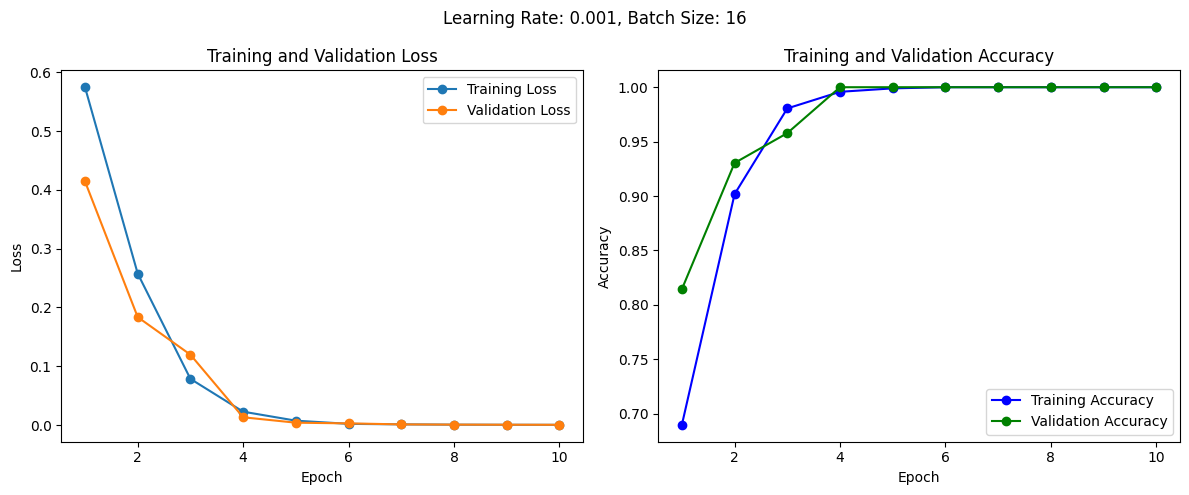

Test Accuracy: 0.9979

Experiment: Learning Rate = 0.001, Batch Size = 32
Epoch 1/10, Training Loss: 0.6031, Training Accuracy: 0.6778, Validation Loss: 0.4763, Validation Accuracy: 0.7932
Epoch 2/10, Training Loss: 0.3114, Training Accuracy: 0.8836, Validation Loss: 0.2381, Validation Accuracy: 0.9219
Epoch 3/10, Training Loss: 0.1470, Training Accuracy: 0.9560, Validation Loss: 0.1147, Validation Accuracy: 0.9705
Epoch 4/10, Training Loss: 0.0583, Training Accuracy: 0.9863, Validation Loss: 0.0396, Validation Accuracy: 0.9916
Epoch 5/10, Training Loss: 0.0229, Training Accuracy: 0.9971, Validation Loss: 0.0184, Validation Accuracy: 1.0000
Epoch 6/10, Training Loss: 0.0084, Training Accuracy: 0.9995, Validation Loss: 0.0061, Validation Accuracy: 1.0000
Epoch 7/10, Training Loss: 0.0037, Training Accuracy: 1.0000, Validation Loss: 0.0037, Validation Accuracy: 1.0000
Epoch 8/10, Training Loss: 0.0022, Training Accuracy: 1.0000, Validation Loss: 0.0023, Validation Accuracy: 1.0000
Epoch 

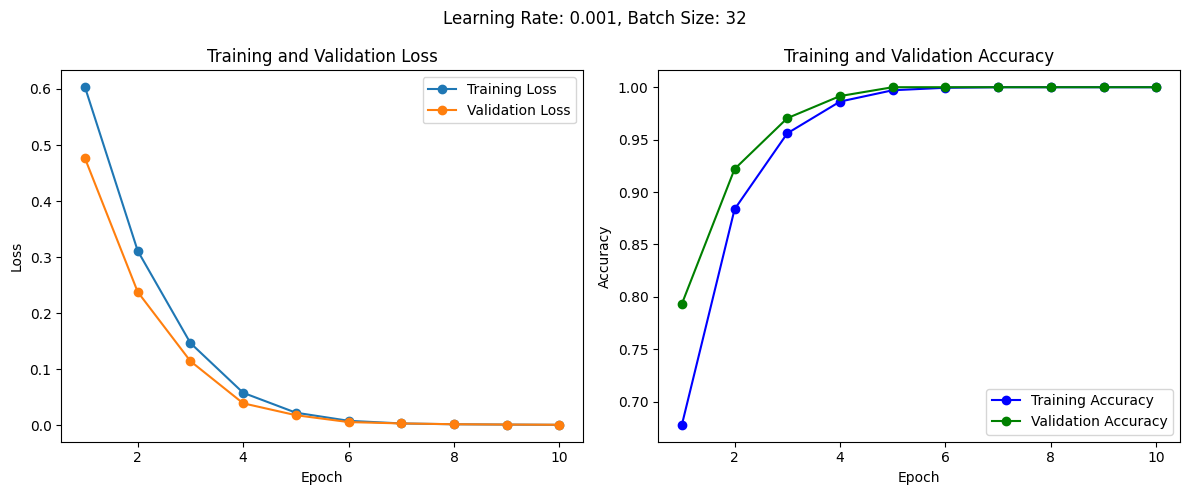

Test Accuracy: 0.9979

Experiment: Learning Rate = 0.001, Batch Size = 64
Epoch 1/10, Training Loss: 0.6810, Training Accuracy: 0.6154, Validation Loss: 0.5674, Validation Accuracy: 0.7363
Epoch 2/10, Training Loss: 0.4965, Training Accuracy: 0.7703, Validation Loss: 0.4447, Validation Accuracy: 0.8038
Epoch 3/10, Training Loss: 0.3380, Training Accuracy: 0.8707, Validation Loss: 0.3166, Validation Accuracy: 0.8861
Epoch 4/10, Training Loss: 0.1897, Training Accuracy: 0.9436, Validation Loss: 0.1904, Validation Accuracy: 0.9346
Epoch 5/10, Training Loss: 0.1116, Training Accuracy: 0.9752, Validation Loss: 0.1095, Validation Accuracy: 0.9768
Epoch 6/10, Training Loss: 0.0658, Training Accuracy: 0.9879, Validation Loss: 0.0743, Validation Accuracy: 0.9789
Epoch 7/10, Training Loss: 0.0287, Training Accuracy: 0.9979, Validation Loss: 0.0314, Validation Accuracy: 0.9979
Epoch 8/10, Training Loss: 0.0186, Training Accuracy: 0.9979, Validation Loss: 0.0179, Validation Accuracy: 1.0000
Epoch 

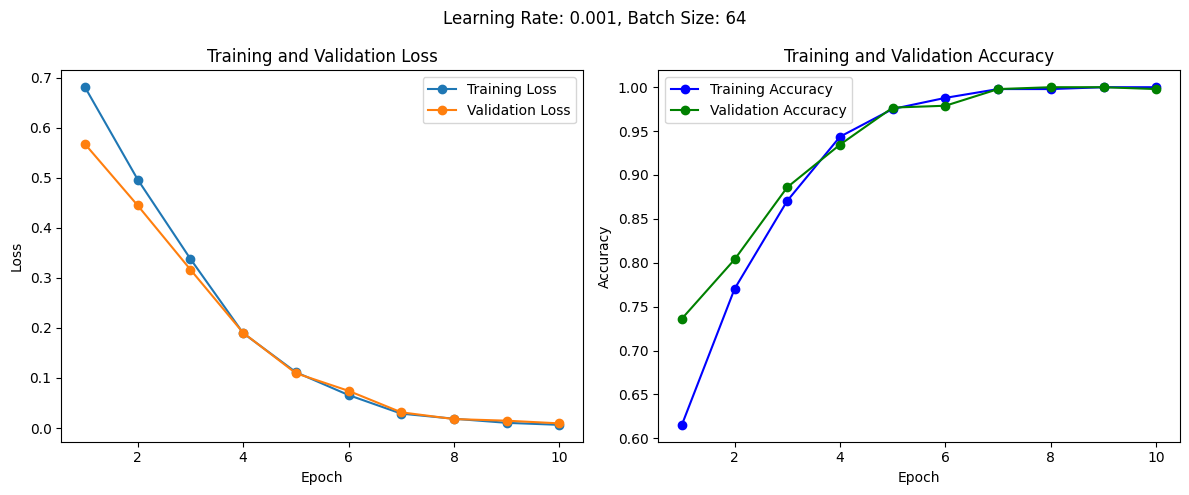

Test Accuracy: 0.9979

Experiment: Learning Rate = 0.01, Batch Size = 16
Epoch 1/10, Training Loss: 0.8014, Training Accuracy: 0.4976, Validation Loss: 0.6977, Validation Accuracy: 0.4873
Epoch 2/10, Training Loss: 0.6944, Training Accuracy: 0.4934, Validation Loss: 0.6930, Validation Accuracy: 0.5127
Epoch 3/10, Training Loss: 0.6933, Training Accuracy: 0.5092, Validation Loss: 0.6973, Validation Accuracy: 0.4873
Epoch 4/10, Training Loss: 0.6941, Training Accuracy: 0.4934, Validation Loss: 0.6932, Validation Accuracy: 0.4873
Epoch 5/10, Training Loss: 0.6939, Training Accuracy: 0.4881, Validation Loss: 0.6937, Validation Accuracy: 0.5127
Epoch 6/10, Training Loss: 0.6941, Training Accuracy: 0.4997, Validation Loss: 0.6943, Validation Accuracy: 0.4873
Epoch 7/10, Training Loss: 0.6936, Training Accuracy: 0.5061, Validation Loss: 0.6930, Validation Accuracy: 0.5127
Epoch 8/10, Training Loss: 0.6945, Training Accuracy: 0.4892, Validation Loss: 0.6933, Validation Accuracy: 0.5127
Epoch 9

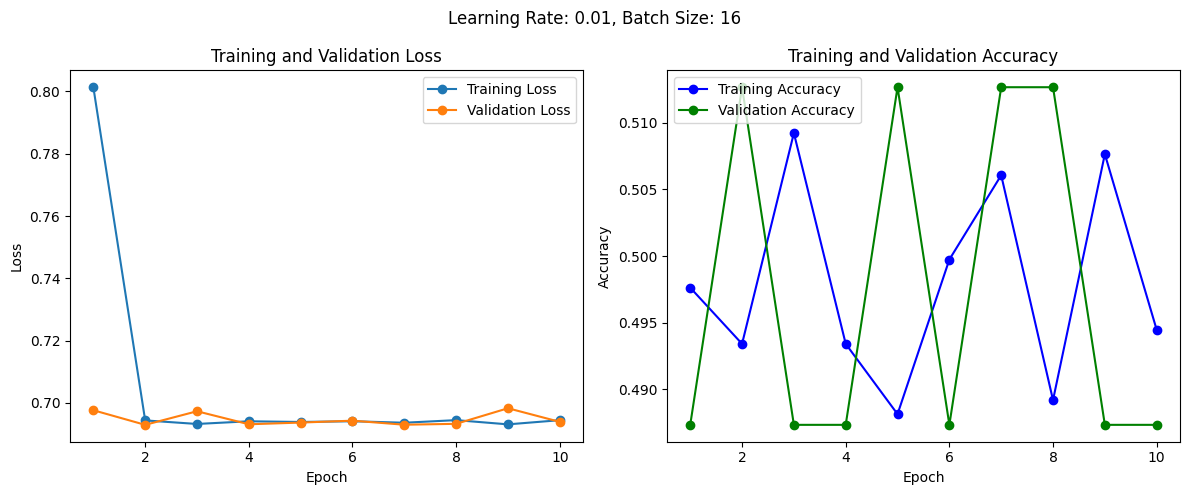

Test Accuracy: 0.5105

Experiment: Learning Rate = 0.01, Batch Size = 32
Epoch 1/10, Training Loss: 0.8547, Training Accuracy: 0.4918, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 2/10, Training Loss: 0.6936, Training Accuracy: 0.4860, Validation Loss: 0.6931, Validation Accuracy: 0.5127
Epoch 3/10, Training Loss: 0.6935, Training Accuracy: 0.5082, Validation Loss: 0.6951, Validation Accuracy: 0.4873
Epoch 4/10, Training Loss: 0.6939, Training Accuracy: 0.4960, Validation Loss: 0.6934, Validation Accuracy: 0.4873
Epoch 5/10, Training Loss: 0.6939, Training Accuracy: 0.4871, Validation Loss: 0.6942, Validation Accuracy: 0.4873
Epoch 6/10, Training Loss: 0.6940, Training Accuracy: 0.4787, Validation Loss: 0.6930, Validation Accuracy: 0.5127
Epoch 7/10, Training Loss: 0.6935, Training Accuracy: 0.5040, Validation Loss: 0.6960, Validation Accuracy: 0.4873
Epoch 8/10, Training Loss: 0.6940, Training Accuracy: 0.4897, Validation Loss: 0.6931, Validation Accuracy: 0.5127
Epoch 9

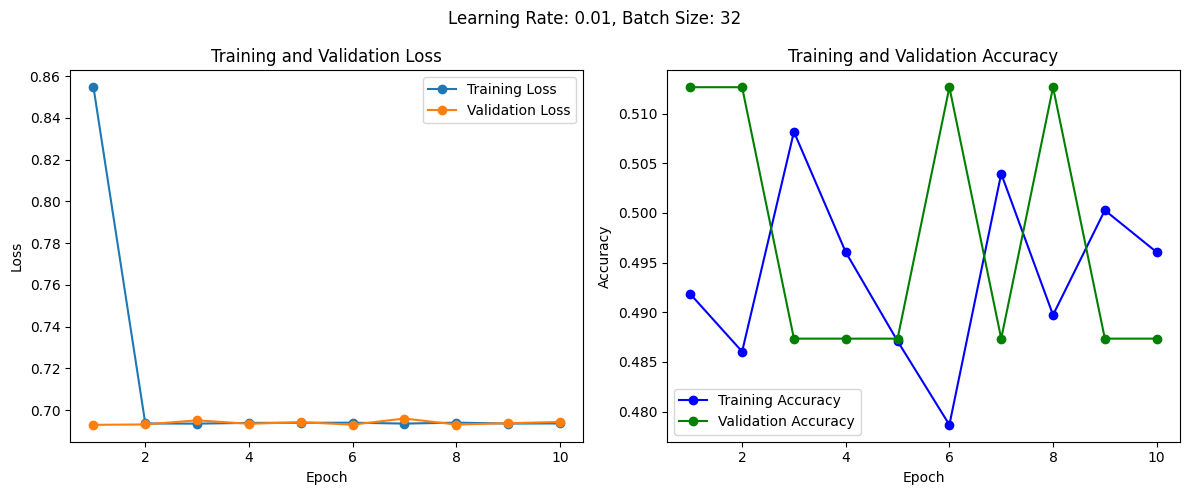

Test Accuracy: 0.5105

Experiment: Learning Rate = 0.01, Batch Size = 64
Epoch 1/10, Training Loss: 1.0932, Training Accuracy: 0.4982, Validation Loss: 0.6935, Validation Accuracy: 0.4873
Epoch 2/10, Training Loss: 0.6933, Training Accuracy: 0.5008, Validation Loss: 0.6932, Validation Accuracy: 0.4873
Epoch 3/10, Training Loss: 0.6934, Training Accuracy: 0.4992, Validation Loss: 0.6944, Validation Accuracy: 0.4873
Epoch 4/10, Training Loss: 0.6938, Training Accuracy: 0.5029, Validation Loss: 0.6927, Validation Accuracy: 0.5127
Epoch 5/10, Training Loss: 0.6935, Training Accuracy: 0.4960, Validation Loss: 0.6927, Validation Accuracy: 0.5127
Epoch 6/10, Training Loss: 0.6935, Training Accuracy: 0.4913, Validation Loss: 0.6930, Validation Accuracy: 0.5127
Epoch 7/10, Training Loss: 0.6935, Training Accuracy: 0.4913, Validation Loss: 0.6931, Validation Accuracy: 0.5127
Epoch 8/10, Training Loss: 0.6933, Training Accuracy: 0.4908, Validation Loss: 0.6937, Validation Accuracy: 0.4873
Epoch 9

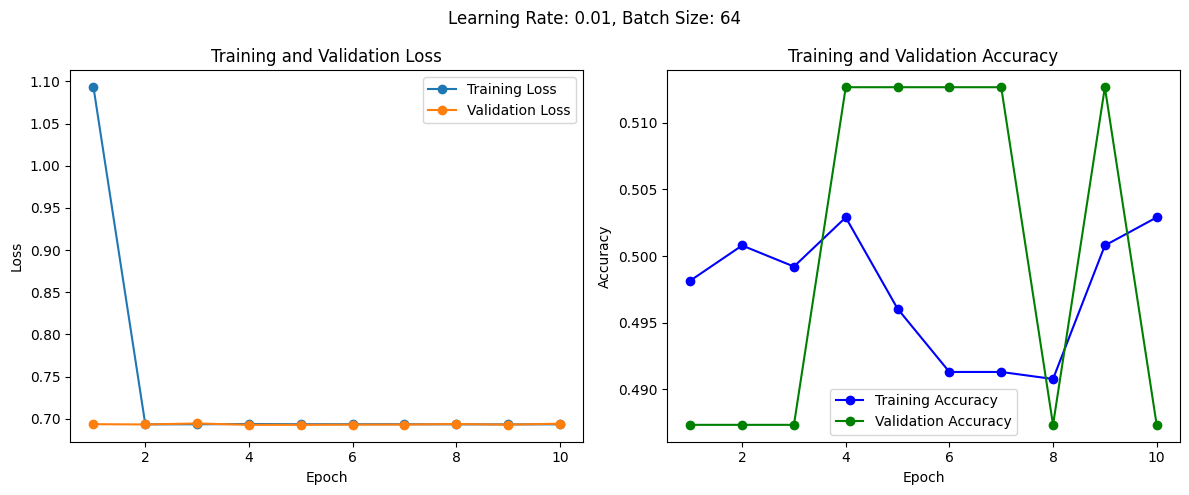

Test Accuracy: 0.5105

Experiment: Learning Rate = 0.1, Batch Size = 16
Epoch 1/10, Training Loss: 16.8339, Training Accuracy: 0.4997, Validation Loss: 0.6940, Validation Accuracy: 0.4873
Epoch 2/10, Training Loss: 0.6994, Training Accuracy: 0.4945, Validation Loss: 0.6941, Validation Accuracy: 0.4873
Epoch 3/10, Training Loss: 0.6964, Training Accuracy: 0.5034, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 4/10, Training Loss: 0.7004, Training Accuracy: 0.5013, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 5/10, Training Loss: 0.6985, Training Accuracy: 0.4955, Validation Loss: 0.6946, Validation Accuracy: 0.4873
Epoch 6/10, Training Loss: 0.6997, Training Accuracy: 0.5103, Validation Loss: 0.7048, Validation Accuracy: 0.5127
Epoch 7/10, Training Loss: 0.6985, Training Accuracy: 0.5071, Validation Loss: 0.7058, Validation Accuracy: 0.5127
Epoch 8/10, Training Loss: 0.6993, Training Accuracy: 0.4934, Validation Loss: 0.6967, Validation Accuracy: 0.5127
Epoch 9

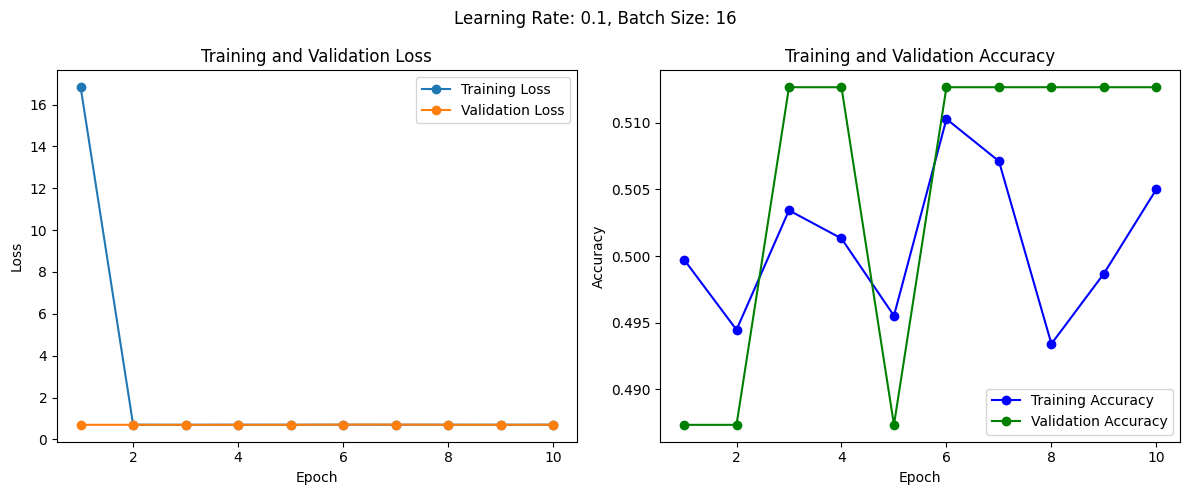

Test Accuracy: 0.4895

Experiment: Learning Rate = 0.1, Batch Size = 32
Epoch 1/10, Training Loss: 19.9883, Training Accuracy: 0.4982, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 2/10, Training Loss: 0.6960, Training Accuracy: 0.4966, Validation Loss: 0.6930, Validation Accuracy: 0.5127
Epoch 3/10, Training Loss: 0.6961, Training Accuracy: 0.5003, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 4/10, Training Loss: 0.6963, Training Accuracy: 0.4945, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 5/10, Training Loss: 0.6961, Training Accuracy: 0.5008, Validation Loss: 0.7035, Validation Accuracy: 0.4873
Epoch 6/10, Training Loss: 0.6980, Training Accuracy: 0.5045, Validation Loss: 0.7053, Validation Accuracy: 0.4873
Epoch 7/10, Training Loss: 0.7003, Training Accuracy: 0.4918, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 8/10, Training Loss: 0.6982, Training Accuracy: 0.5003, Validation Loss: 0.6929, Validation Accuracy: 0.5127
Epoch 9

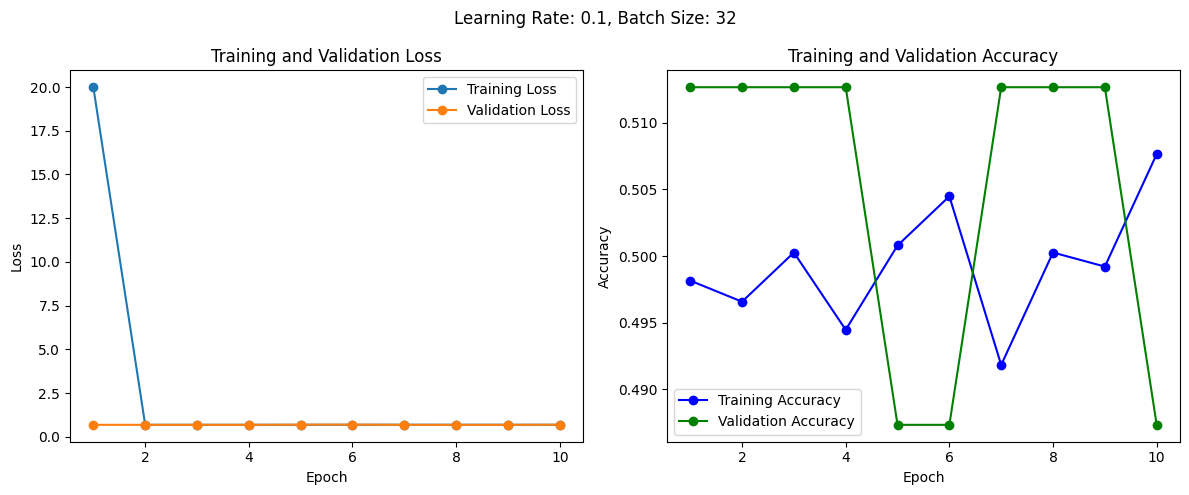

Test Accuracy: 0.5105

Experiment: Learning Rate = 0.1, Batch Size = 64
Epoch 1/10, Training Loss: 75.3243, Training Accuracy: 0.5042, Validation Loss: 0.6983, Validation Accuracy: 0.4873
Epoch 2/10, Training Loss: 0.6944, Training Accuracy: 0.4966, Validation Loss: 0.6927, Validation Accuracy: 0.5127
Epoch 3/10, Training Loss: 0.6939, Training Accuracy: 0.5024, Validation Loss: 0.6948, Validation Accuracy: 0.4873
Epoch 4/10, Training Loss: 0.6933, Training Accuracy: 0.5108, Validation Loss: 0.6958, Validation Accuracy: 0.4873
Epoch 5/10, Training Loss: 0.6943, Training Accuracy: 0.5087, Validation Loss: 0.7052, Validation Accuracy: 0.4873
Epoch 6/10, Training Loss: 0.6969, Training Accuracy: 0.4976, Validation Loss: 0.6940, Validation Accuracy: 0.5127
Epoch 7/10, Training Loss: 0.6988, Training Accuracy: 0.4945, Validation Loss: 0.6941, Validation Accuracy: 0.4873
Epoch 8/10, Training Loss: 0.6951, Training Accuracy: 0.5008, Validation Loss: 0.7017, Validation Accuracy: 0.5127
Epoch 9

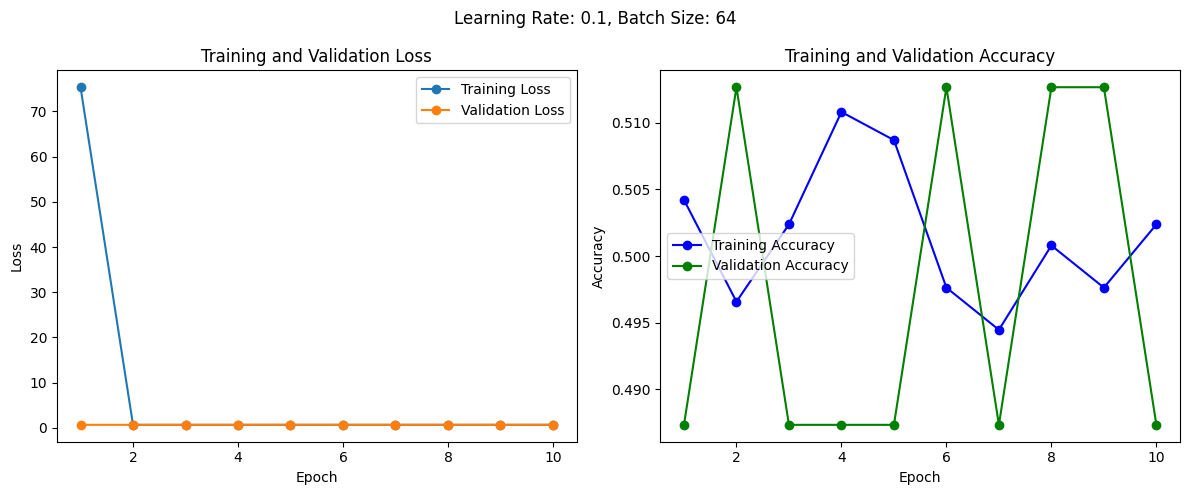

Test Accuracy: 0.5105
Trained model saved at: simple_cnn_model.pth
Predicted class index for image C:\Users\Prodigy-\Desktop\123\dataset\dog\dog_0012.jpg: -1


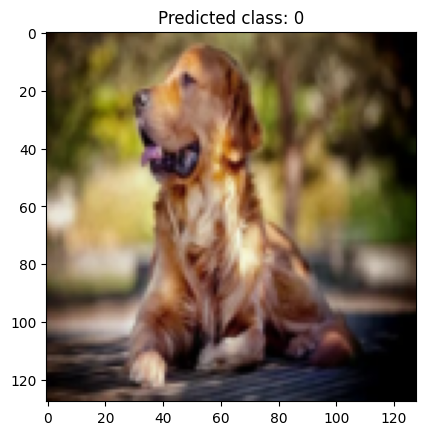

Predicted class index for image C:\Users\Prodigy-\Desktop\123\dataset\cat\cat_0410.jpg: -1


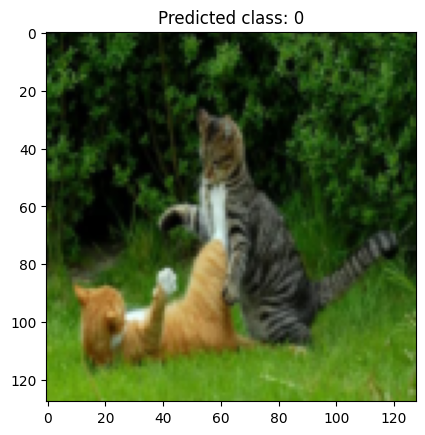

In [17]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    img_train, labels_train, img_val, labels_val, img_test, labels_test = load_dataset("C:/Users/Prodigy-/Desktop/python/Lab5/dataset.csv")

    unique_labels = list(set(labels_train + labels_val + labels_test))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    trained_model = main("dataset.csv", num_epochs=10)

    model_save_path = "simple_cnn_model.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Trained model saved at: {model_save_path}")

    new_model = SimpleCNN(num_classes=len(unique_labels)).to(device)
    new_model.load_state_dict(torch.load(model_save_path, map_location=device))
    new_model.eval()

    img_paths = [
        r"C:\Users\Prodigy-\Desktop\123\dataset\dog\dog_0012.jpg",
        r"C:\Users\Prodigy-\Desktop\123\dataset\cat\cat_0410.jpg",
    ]

    for img_path in img_paths:
        img = Image.open(img_path).convert("RGB")

        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        sample_image = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = new_model(sample_image)
            _, predicted_class = torch.max(output, 1)

        predicted_class_index = predicted_class.item() - 0
        print(f"Predicted class index for image {img_path}: {predicted_class_index}")


        img_array = transforms.ToPILImage()(sample_image.squeeze(0).cpu())
        plt.imshow(img_array)
        plt.title(f"Predicted class: {predicted_class.item()}")
        plt.show()

Модели, обученные с коэффициентом обучения 0.001 и различными размерами пакета, показали хорошие результаты, достигнув высокой точности как на обучающем, так и на валидационном наборе данных. Однако, когда коэффициент обучения был увеличен до 0.01 и 0.1, а также с увеличением размера пакета, производительность модели значительно ухудшилась.

Похоже, что коэффициент обучения 0.001 с размером пакета 16, 32 или 64 наиболее подходит для этой задачи